In [1]:
import os
import warnings
import pandas as pd
import networkx as nx
import matplotlib as mpl
from empiricaldist import Cdf
from collections import Counter
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from bokeh.plotting import figure
import matplotlib.colors as mcolors
from utils import decorate, savefig
from bokeh.transform import linear_cmap
from bokeh.plotting import from_networkx
from bokeh.io import output_notebook, show, save
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8,Inferno
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, ColorBar, LabelSet, LogColorMapper

# Chennai

In [2]:
#caricamento network
edgelist = pd.read_csv("cbn.txt",sep="	")
#network pesata
G_pesato = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph(), source="Source", target="Target", edge_attr=["Weight"])
#network non pesata
G_non_pesato = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph(), source="Source", target="Target", edge_attr=None)
#lista di nodi
nodi= edgelist["Source"].unique()
df_nodi= pd.DataFrame(nodi)
df_nodi=df_nodi.rename(columns={0:"id"})
#creazione data frame network
data = df_nodi.set_index('id').to_dict('index').items()
G_non_pesato.add_nodes_from(data)
G_pesato.add_nodes_from(data)
print('NODI:\n',len(G_pesato.nodes))
print('\nLINKS:\n',len(G_pesato.edges))

NODI:
 1009

LINKS:
 1610


# Matrice di Adiacenza

In [3]:
nodelist = list(G_pesato.nodes)
mat_adj = nx.to_pandas_adjacency(G_pesato, dtype=int)
mat_adj

1     479   601   2     385   1085  3     114   116   469   ...  1091  \
1        0     1     1     0     0     0     0     0     0     0  ...     0   
479      1     0     0     0     0     0     0     0     0     0  ...     0   
601      1     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     1     1     0     0     0     0  ...     0   
385      0     0     0     1     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1118     0     0     0     0     0     0     0     0     0     0  ...     0   
1111     0     0     0     0     0     0     0     0     0     0  ...     0   
1120     0     0     0     0     0     0     0     0     0     0  ...     0   
1161     0     0     0     0     0     0     0     0     0     0  ...     0   
1180     0     0     0     0     0     0     0     0     0     0  ...     0   

      1115  1060  1069  1071  1118  1111  1120  1161  1180  
1        0     0     0     0     0     0     0     0     0  
479      0     0     0     0     0     0     0     0     0  
601      0     0     0     0     0     0     0     0     0  
2        0     0     0     0     0     0     0     0     0  
385      0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
1118     0     0     0     0     0     0     0     0     0  
1111     0     0     0     0     0     0     0     0     0  
1120     0     0     0     0     0     0     0     0     0  
1161     0     0     0     0     0     0     0     0     0  
1180     0     0     0     0     0     0     0     0     0  

[1009 rows x 1009 columns]

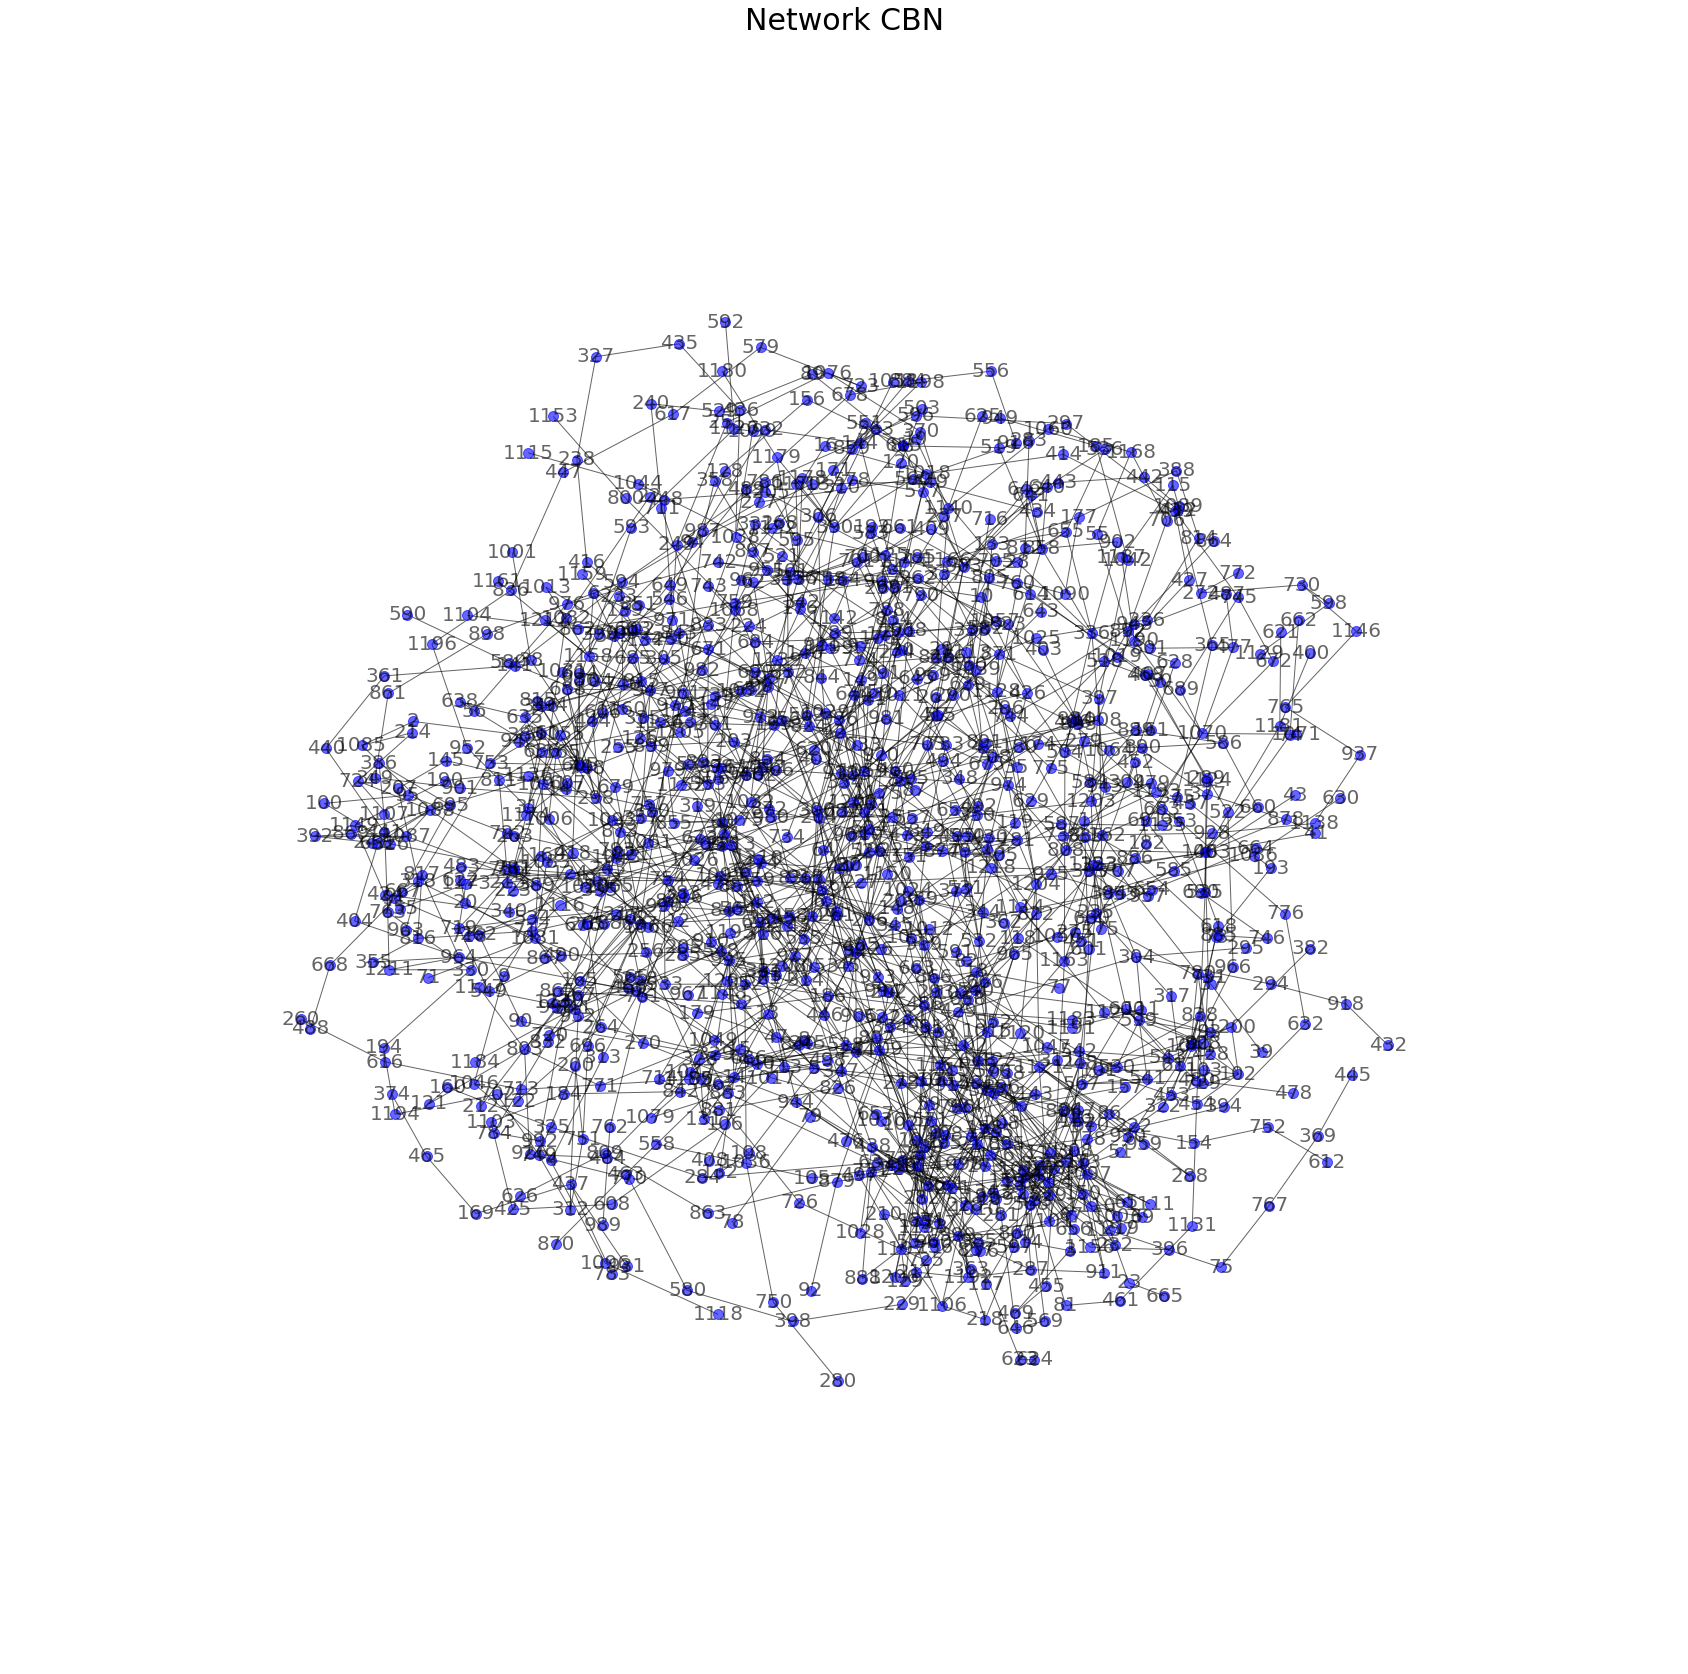

In [4]:
pos = nx.spring_layout(G_pesato, k=0.1)
plt.rcParams["figure.figsize"] = (30,30)
nx.draw_networkx(G_pesato, pos=pos, node_size=100, edge_color="black", alpha=0.6, with_labels=True,
                node_color="blue",font_size=20,font_color="black")
plt.title("Network CBN", fontsize=30)
ax = plt.gca()
ax.margins(0.20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis("off")

plt.show()

## Large scale

In [5]:
#La rete è connesssa?
print('\nNetwork is connected?\n',nx.is_connected(G_pesato))                          
comps = sorted(nx.connected_components(G_pesato),
               key=len, reverse=True)



Network is connected?
 True


In [6]:
#average path length
apl=[]
apl.append((round(nx.average_shortest_path_length(G_non_pesato),3)))
apl.append((round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
df=pd.DataFrame([apl],columns=["Network non pesata","Network pesata"])
#diametro
diametro=[]
diametro.append(nx.diameter(G_non_pesato))
diametro.append(nx.diameter(G_pesato))
df_length = len(df)
df.loc[df_length] = diametro
#density
density=[]
density.append(round(nx.density(G_non_pesato),4))
density.append(round(nx.density(G_pesato),4))
df_length = len(df)
df.loc[df_length] = density
# average local clustering
alc=[]
alc.append(round(nx.average_clustering(G_non_pesato),4))
alc.append(round(nx.average_clustering(G_pesato,weight='Weight'),4))
df_length = len(df)
df.loc[df_length] = alc
#global clustering
global_clustering=[]
global_clustering.append(round(nx.transitivity(G_non_pesato),3))
global_clustering.append(round(nx.transitivity(G_pesato),3))
df_length = len(df)
df.loc[df_length] = global_clustering
indici=["Average Path Length","Diametro","Density","Average Local Clustering","Global Clustering"]
df.index =indici
df


Network non pesata  Network pesata
Average Path Length                   8.7300         23.6050
Diametro                             27.0000         27.0000
Density                               0.0032          0.0032
Average Local Clustering              0.0678          0.0021
Global Clustering                     0.1050          0.1050

# Small scale

In [7]:
#calcolo del grado per la network pesata e non pesata
nx.set_node_attributes(G_non_pesato, name='unweighted_degree', values=dict(nx.degree(G_non_pesato)))
nx.set_node_attributes(G_pesato, name='unweighted_degree', values=dict(nx.degree(G_pesato)))
nx.set_node_attributes(G_pesato, name='weighted_degree', values=dict(nx.degree(G_pesato, weight='Weight')))

#calcolo degree centrality
nx.set_node_attributes(G_non_pesato, name='degree_centrality', values=nx.degree_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='degree_centrality', values=nx.degree_centrality(G_pesato))

#calcolo betweeness centrality
nx.set_node_attributes(G_non_pesato, name='betweenness', values=nx.betweenness_centrality(G_non_pesato, normalized=True))
nx.set_node_attributes(G_pesato, name='betweenness', values=nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight"))

#calcolo closeness
nx.set_node_attributes(G_non_pesato, name='closeness', values=nx.closeness_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='closeness', values=nx.closeness_centrality(G_pesato))

#calcolo eigenvector
nx.set_node_attributes(G_non_pesato, name='eigenvector', values=nx.eigenvector_centrality(G_non_pesato,max_iter=1000))
nx.set_node_attributes(G_pesato, name='eigenvector', values=nx.eigenvector_centrality(G_pesato, weight="Weight",max_iter=1000))

#calcolo page rank
nx.set_node_attributes(G_non_pesato, name='page_rank', values=nx.pagerank(G_non_pesato))
nx.set_node_attributes(G_pesato, name='page_rank', values=nx.pagerank(G_pesato, weight="Weight"))

In [8]:
#creazione del data frame con le varie misure small scale per la rete non pesata
unweightedDF = pd.DataFrame(dict(G_non_pesato.nodes(data=True))).T
unweightedDF

unweighted_degree  degree_centrality  betweenness  closeness  \
1                   2.0           0.001984     0.001063   0.106520   
479                 2.0           0.001984     0.001681   0.111776   
601                 2.0           0.001984     0.001854   0.113004   
2                   2.0           0.001984     0.001361   0.112199   
385                 3.0           0.002976     0.003555   0.123227   
...                 ...                ...          ...        ...   
1118                1.0           0.000992     0.000000   0.086257   
1111                2.0           0.001984     0.000004   0.121431   
1120                2.0           0.001984     0.001986   0.126016   
1161                1.0           0.000992     0.000000   0.120014   
1180                1.0           0.000992     0.000000   0.120344   

       eigenvector  page_rank  
1     3.612344e-05   0.000767  
479   3.179638e-05   0.000745  
601   2.080542e-04   0.000709  
2     2.198701e-04   0.000664  
385   9.564385e-04   0.000882  
...            ...        ...  
1118  8.051566e-08   0.000564  
1111  4.103233e-02   0.000471  
1120  5.443404e-03   0.000576  
1161  9.155350e-04   0.000379  
1180  1.163458e-04   0.000445  

[1009 rows x 6 columns]

In [10]:
#creazione del data frame con le varie misure small scale per la rete pesata
weightedDF = pd.DataFrame(dict(G_pesato.nodes(data=True))).T
weightedDF

unweighted_degree  weighted_degree  degree_centrality  betweenness  \
1                   2.0              2.0           0.001984     0.009074   
479                 2.0              2.0           0.001984     0.008939   
601                 2.0              2.0           0.001984     0.010045   
2                   2.0             17.0           0.001984     0.000002   
385                 3.0             21.0           0.002976     0.001557   
...                 ...              ...                ...          ...   
1118                1.0              1.0           0.000992     0.000000   
1111                2.0              8.0           0.001984     0.000000   
1120                2.0              2.0           0.001984     0.009399   
1161                1.0              1.0           0.000992     0.000000   
1180                1.0              1.0           0.000992     0.000000   

      closeness   eigenvector  page_rank  
1      0.106520  3.950081e-13   0.000513  
479    0.111776  1.066507e-10   0.000435  
601    0.113004  9.028704e-13   0.000422  
2      0.112199  3.887260e-07   0.000848  
385    0.123227  9.350322e-06   0.001077  
...         ...           ...        ...  
1118   0.086257  1.304020e-19   0.000426  
1111   0.121431  8.117293e-06   0.000285  
1120   0.126016  4.761758e-06   0.000198  
1161   0.120014  5.636952e-05   0.000169  
1180   0.120344  6.979139e-12   0.000236  

[1009 rows x 7 columns]

# Degree

In [11]:
topNodes = 15
unweightedDF["Label"]=unweightedDF.index
weightedDF["Label"]=weightedDF.index

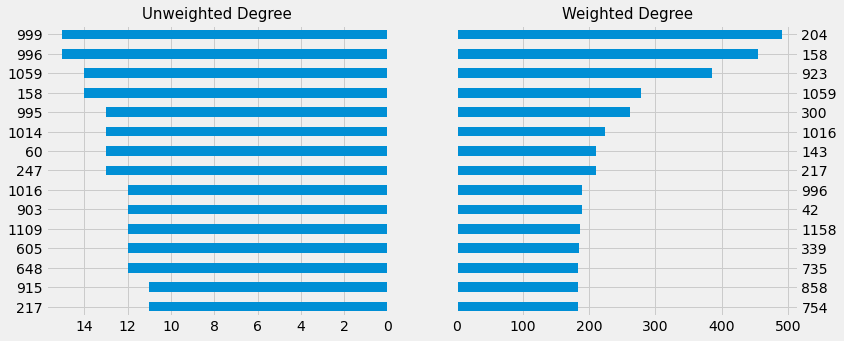

In [13]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')


unweightedDF.sort_values(by='unweighted_degree', ascending=False)[:topNodes].plot(x='Label', y='unweighted_degree', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted Degree", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='weighted_degree', ascending=False)[:topNodes].plot(x='Label', y='weighted_degree', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted Degree", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

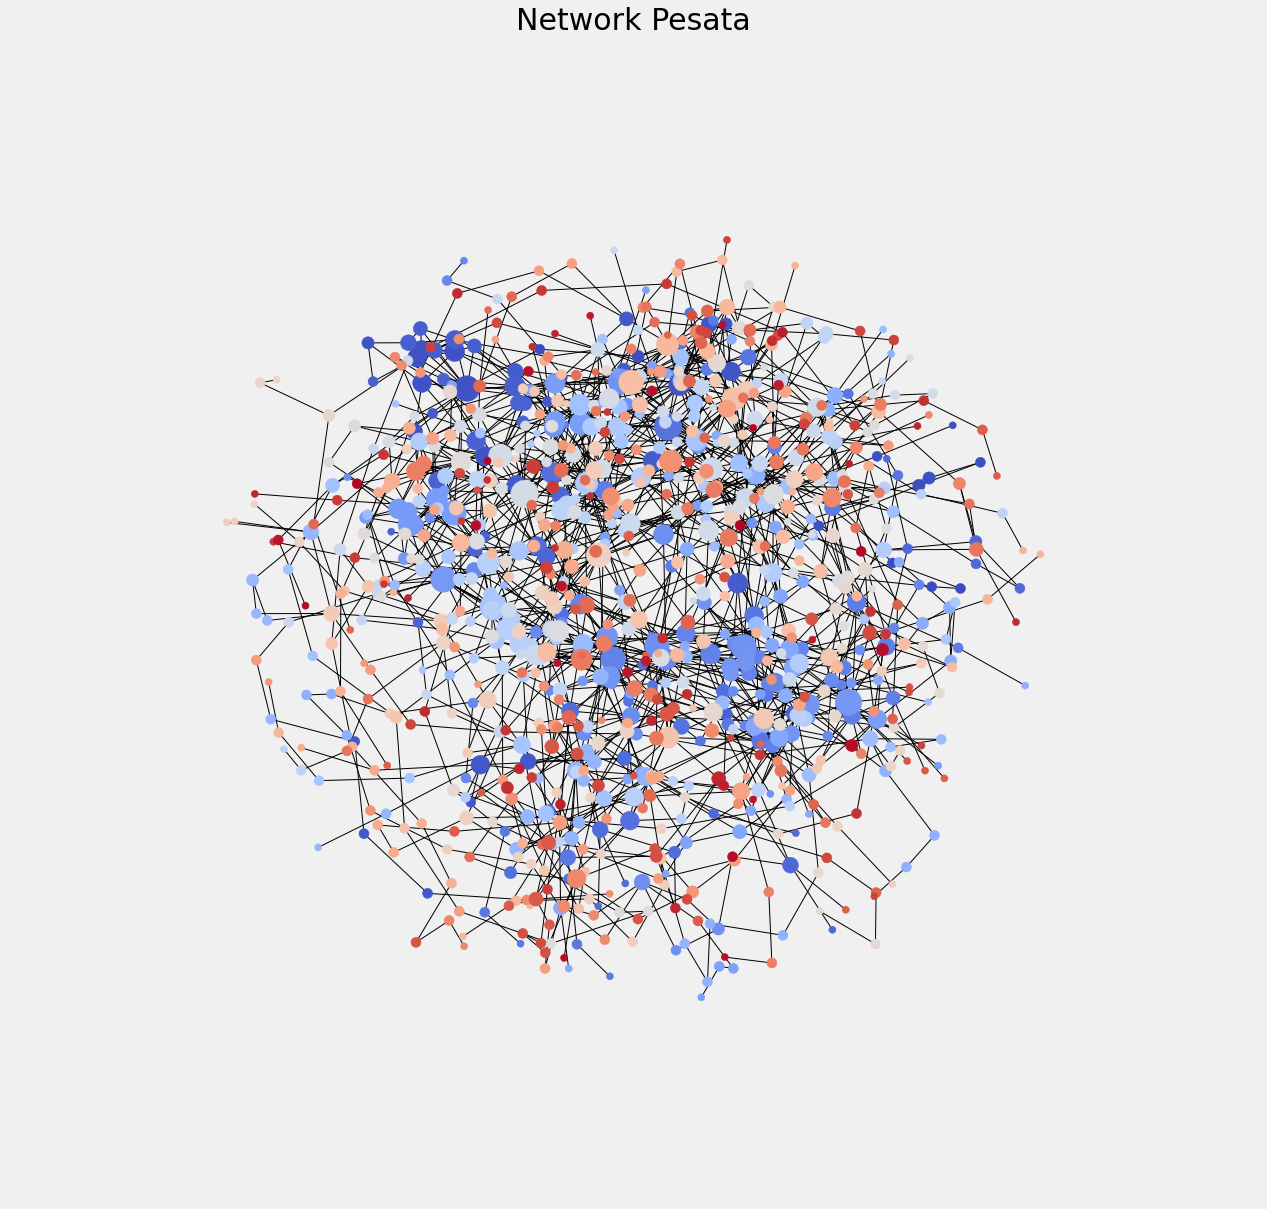

In [14]:
pos = nx.spring_layout(G_pesato, k=0.1)
color_lookup = {k:v for v, k in enumerate(sorted(set(G_pesato.nodes())))}
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
node_colors = [mapper.to_rgba(i) for i in color_lookup.values()]
d = dict(list(nx.degree(G_pesato)))
node_sizes = [v*50 if v <= 30 else v*600 for v in d.values()]
plt.rcParams["figure.figsize"] = (20,20)
nx.draw_networkx(G_pesato, pos=pos, node_size=node_sizes, node_color=node_colors, edge_color="black", with_labels=False, font_size=12)
plt.title("Network Pesata", fontsize=30)
ax = plt.gca()
ax.margins(0.20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis("off")

plt.show()

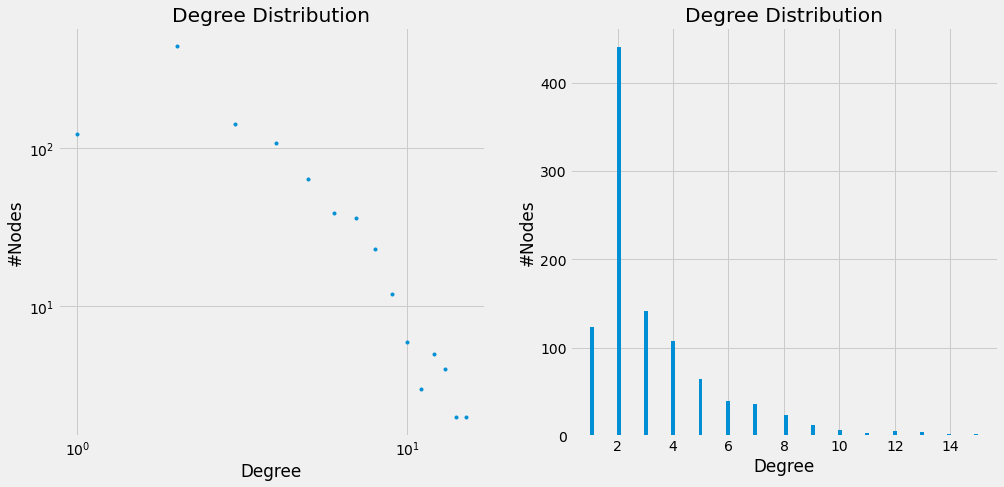

In [15]:
hist = nx.degree_histogram(G_pesato)

plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist)), hist,'.')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

degree_sequence = [G_pesato.degree(n) for n in G_pesato.nodes]

plt.subplot(1, 2, 2)
counts, bins, patches = plt.hist(degree_sequence,bins=100)

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

In [16]:
#creazione di un dataframe per una visualizzazione più rapida dei vari gradi e le relative frequenze
degree_counts = Counter(degree_sequence)
sorted_degree = sorted(degree_counts.items(), 
                       key=lambda item: item[1],reverse=True)
list_gradi=[]
conteggi=[]
for i in range(len(sorted_degree)):
    list_gradi.append(sorted_degree[i][0])
    conteggi.append(sorted_degree[i][1])
df_conteggi=pd.DataFrame(list_gradi,columns=["Grado"])
df_conteggi['Frequenze']=conteggi
df_conteggi

Grado  Frequenze
0       2        441
1       3        142
2       1        123
3       4        107
4       5         64
5       6         39
6       7         36
7       8         23
8       9         12
9      10          6
10     12          5
11     13          4
12     11          3
13     15          2
14     14          2

# Degree Centrality

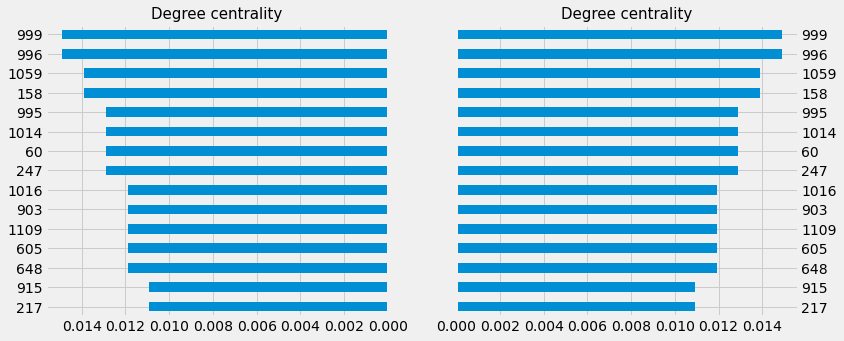

In [17]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')


unweightedDF.sort_values(by='degree_centrality', ascending=False)[:topNodes].plot(x='Label', y='degree_centrality', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Degree centrality", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='degree_centrality', ascending=False)[:topNodes].plot(x='Label', y='degree_centrality', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Degree centrality", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [18]:
if not os.path.isdir('img_cbn'):
    os.mkdir('img_cbn')
title = 'Degree centrality'
adjusted_node_size = dict([(node, 5+degree*250) for node, degree in nx.degree_centrality(G_pesato).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("degree_centrality","@degree_centrality")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.degree_centrality(G_pesato).values()), high=max(nx.degree_centrality(G_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_cbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_cbn\\Degree centrality.html'

# Betwenness

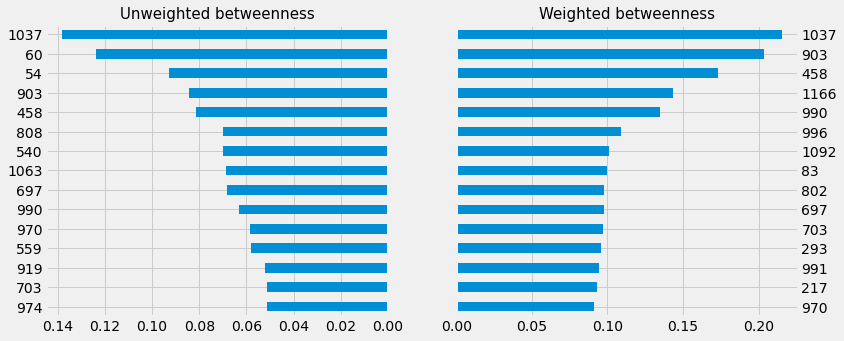

In [19]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='betweenness', ascending=False)[:topNodes].plot(x='Label', y='betweenness', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted betweenness", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='betweenness', ascending=False)[:topNodes].plot(x='Label', y='betweenness', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted betweenness", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

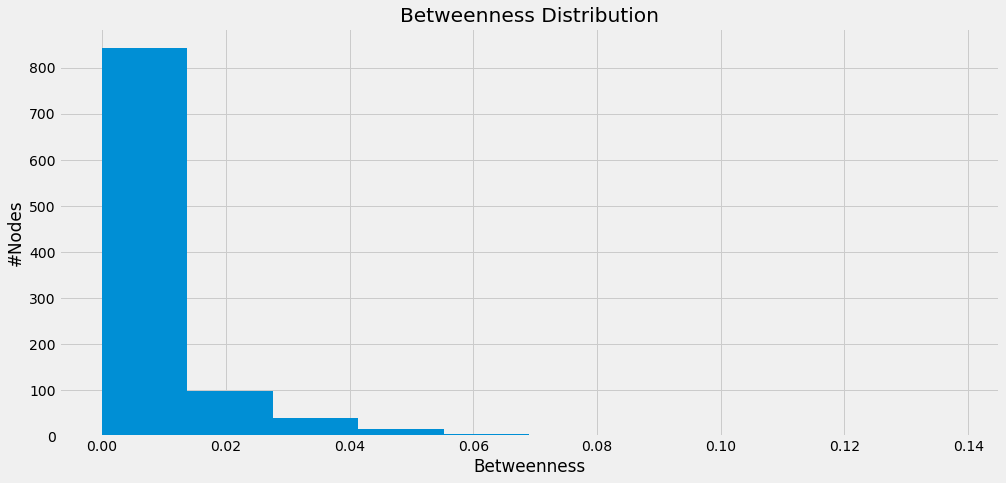

In [20]:
#grafico della distribuzione di frequenze per la betweenness
B = nx.betweenness_centrality(G_pesato,normalized=True)
betweenness_sequence = list(B.values())

counts, bins, patches = plt.hist(betweenness_sequence,bins=10)
plt.title("Betweenness Distribution")
plt.xlabel("Betweenness")
plt.ylabel("#Nodes")
plt.show()

In [21]:
if not os.path.isdir('img_cbn'):             
    os.mkdir('img_cbn')
title = 'Weighted betweenness'
adjusted_node_size = dict([(node, 5+betweenness*175) for node, betweenness in nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("betweenneess","@betweenness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight").values()), high=max(nx.betweenness_centrality(G_pesato, weight="Weight",normalized=True).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_cbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_cbn\\Weighted betweenness.html'

In [22]:
if not os.path.isdir('img_cbn'):             
    os.mkdir('img_cbn')
title = 'Unweighted betweenness'
adjusted_node_size = dict([(node, 5+betweenness*175) for node, betweenness in nx.betweenness_centrality(G_non_pesato, normalized=True).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("betweenneess","@betweenness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.betweenness_centrality(G_non_pesato, normalized=True).values()), high=max(nx.betweenness_centrality(G_non_pesato, normalized=True).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_cbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_cbn\\Unweighted betweenness.html'

# Closeness

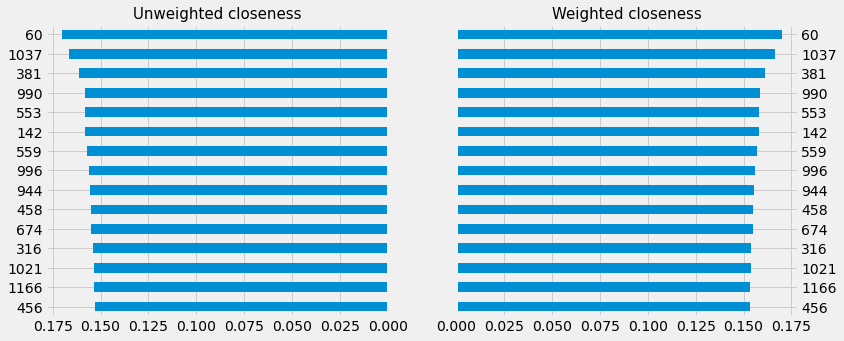

In [23]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='closeness', ascending=False)[:topNodes].plot(x='Label', y='closeness', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted closeness", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='closeness', ascending=False)[:topNodes].plot(x='Label', y='closeness', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted closeness", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [24]:
if not os.path.isdir('img_cbn'):             
    os.mkdir('img_cbn')
title = 'Closeness'
adjusted_node_size = dict([(node, 5+closeness*15) for node, closeness in nx.closeness_centrality(G_pesato).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("closeness","@closeness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.closeness_centrality(G_pesato).values()), high=max(nx.closeness_centrality(G_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_cbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_cbn\\Closeness.html'

# Eigenvector

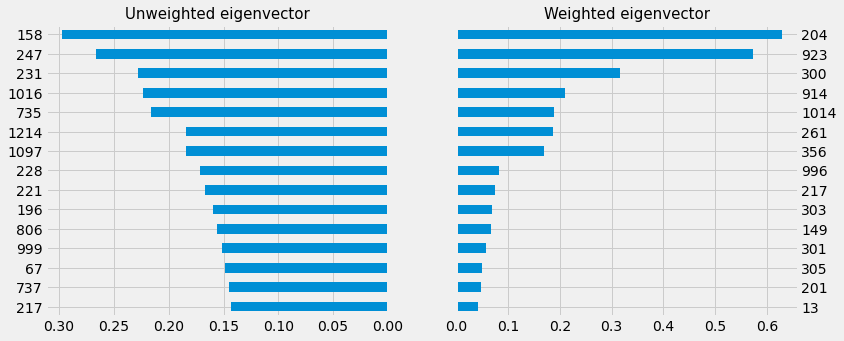

In [25]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='eigenvector', ascending=False)[:topNodes].plot(x='Label', y='eigenvector', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted eigenvector", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='eigenvector', ascending=False)[:topNodes].plot(x='Label', y='eigenvector', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted eigenvector", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [26]:
if not os.path.isdir('img_cbn'):             
    os.mkdir('img_cbn')
title = 'Weighted Eigenvector'
adjusted_node_size = dict([(node, 5+eigenvector*175) for node, eigenvector in nx.eigenvector_centrality(G_pesato,weight="Weight",max_iter=1000).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("eigenvector","@eigenvector")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.eigenvector_centrality(G_pesato,weight="Weight",max_iter=1000).values()), high=max(nx.eigenvector_centrality(G_pesato,weight="Weight",max_iter=1000).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_cbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_cbn\\Weighted Eigenvector.html'

In [27]:
if not os.path.isdir('img_cbn'):             
    os.mkdir('img_cbn')
title = 'Unweighted Eigenvector'
adjusted_node_size = dict([(node, 5+eigenvector*175) for node, eigenvector in nx.eigenvector_centrality(G_non_pesato,max_iter=1000).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("eigenvector","@eigenvector")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.eigenvector_centrality(G_non_pesato,max_iter=1000).values()), high=max(nx.eigenvector_centrality(G_non_pesato,max_iter=1000).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_cbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_cbn\\Unweighted Eigenvector.html'

# Page rank

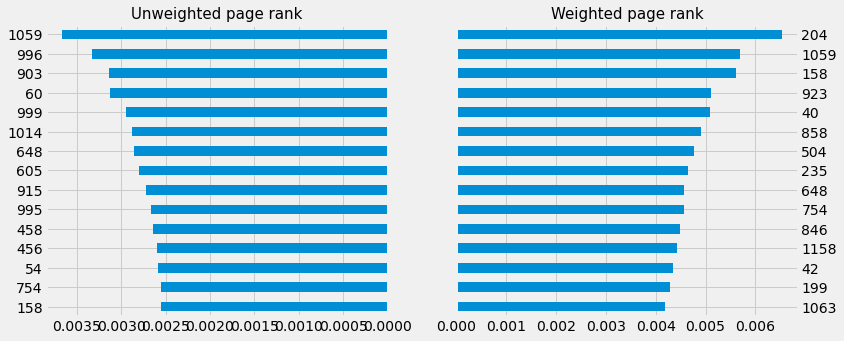

In [28]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='page_rank', ascending=False)[:topNodes].plot(x='Label', y='page_rank', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted page rank", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='page_rank', ascending=False)[:topNodes].plot(x='Label', y='page_rank', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted page rank", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [29]:
if not os.path.isdir('img_cbn'):             
    os.mkdir('img_cbn')
title = 'Weighted Pagerank'
adjusted_node_size = dict([(node, 5+page_rank*900) for node, page_rank in nx.pagerank(G_pesato, weight="Weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("page_rank","@page_rank")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.pagerank(G_pesato, weight="Weight").values()), high=max(nx.pagerank(G_pesato, weight="Weight").values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")
save(plot, filename=f"img_cbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_cbn\\Weighted Pagerank.html'

In [30]:
if not os.path.isdir('img_cbn'):             
    os.mkdir('img_cbn')
title = 'Unweighted Pagerank'
adjusted_node_size = dict([(node, 5+page_rank*900) for node, page_rank in nx.pagerank(G_non_pesato).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("page_rank","@page_rank")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.pagerank(G_non_pesato).values()), high=max(nx.pagerank(G_non_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")
save(plot, filename=f"img_cbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_cbn\\Unweighted Pagerank.html'

# Medium scale

In [31]:
# Find k-cores
G_core_3 = nx.k_core(G_pesato, 3)
G_core_4 = nx.k_core(G_pesato, 4)

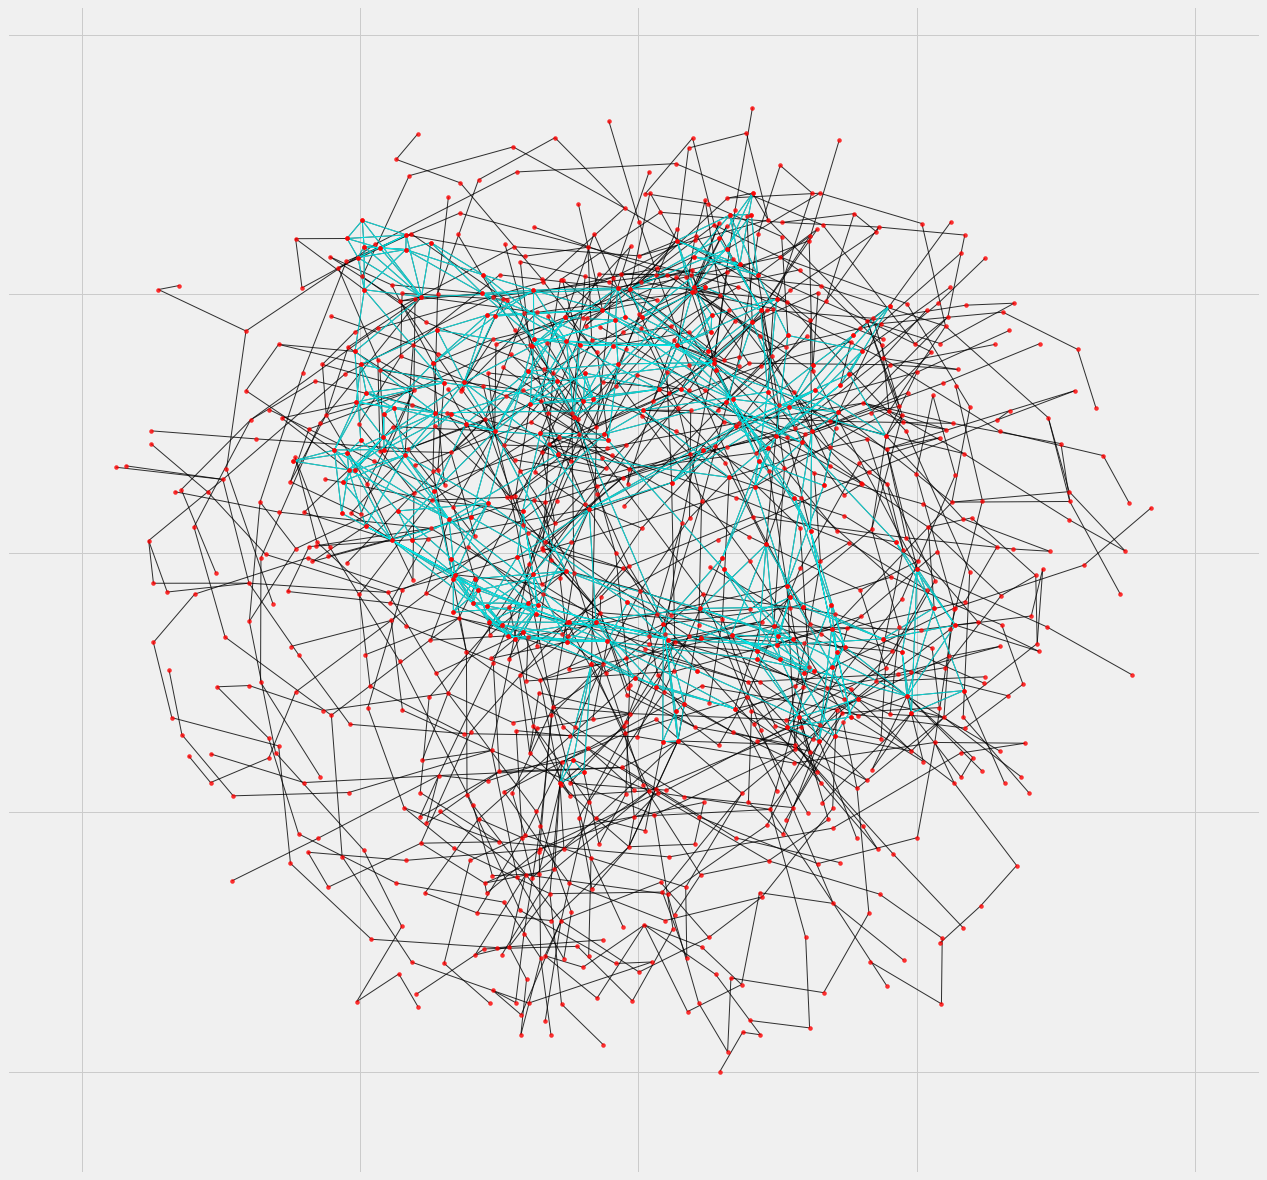

In [33]:
# grafico k kore = 3
nx.draw_networkx(
    G_pesato, pos=pos, node_size=15, edge_color="black", alpha=0.8, with_labels=False,node_color="red")
nx.draw_networkx(
    G_core_3, pos=pos, node_size=15, edge_color="cyan", alpha=0.8, with_labels=False,node_color="red")
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

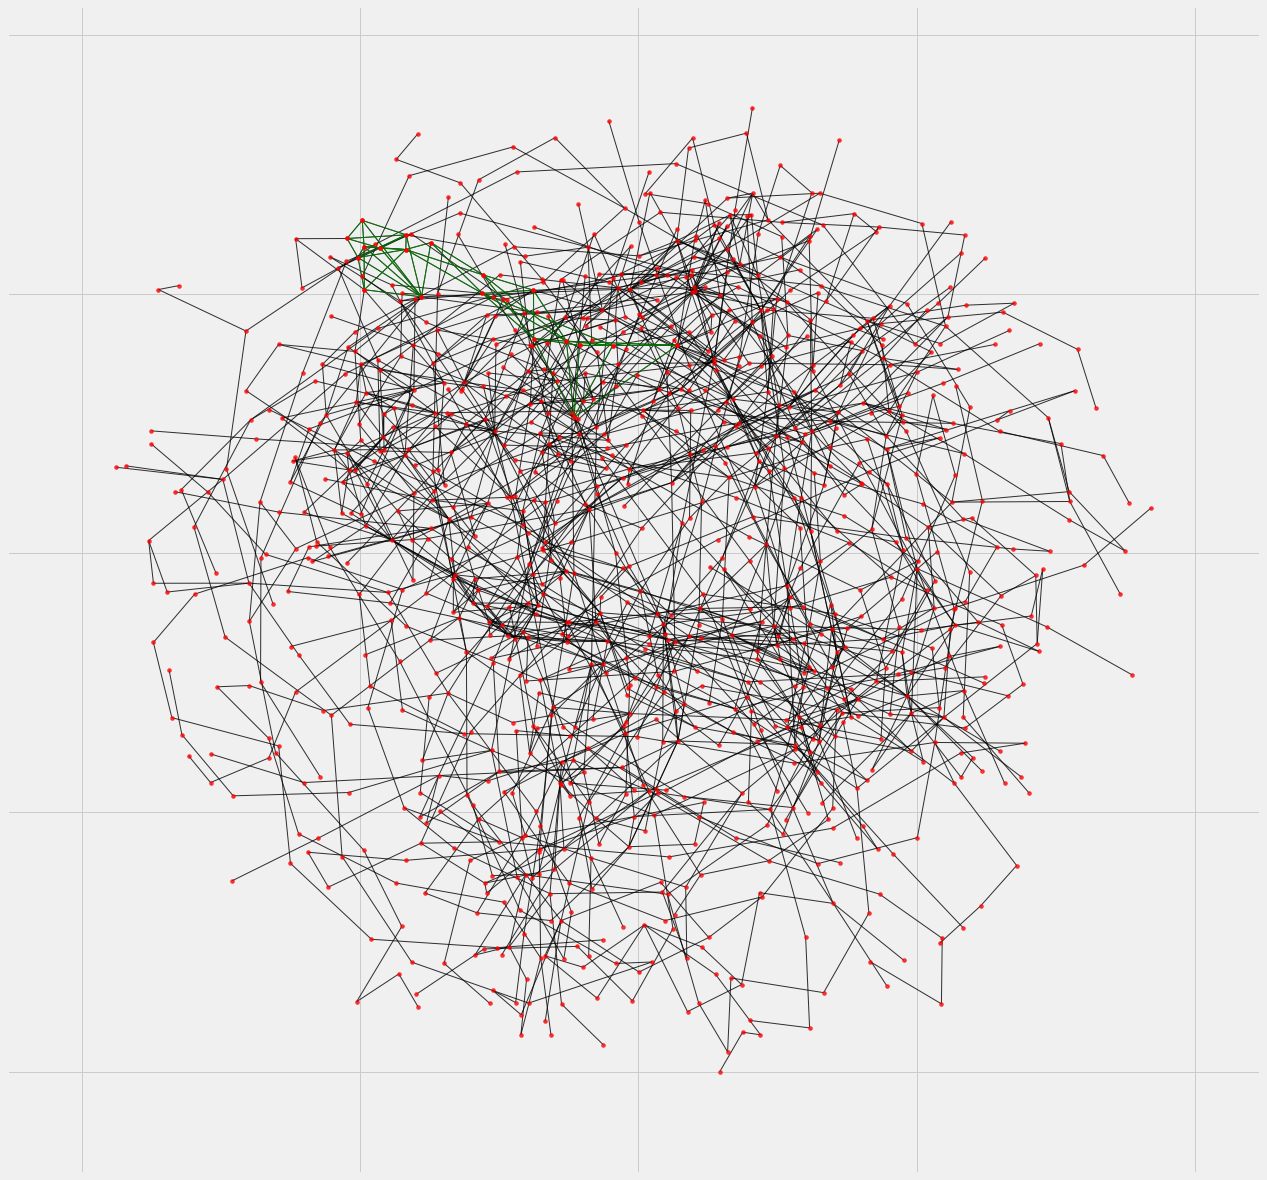

In [34]:
#grafico k kore = 4
nx.draw_networkx(
    G_pesato, pos=pos, node_size=15, edge_color="black", alpha=0.8, with_labels=False,node_color="red")
nx.draw_networkx(
    G_core_4, pos=pos, node_size=15, edge_color="green", alpha=0.8, with_labels=False,node_color="red")
plt.rcParams["figure.figsize"] = (20,20)

In [35]:
def tie_strength(G, v, w):
    # Get neighbors of nodes v and w in G
    v_neighbors = set(G.neighbors(v))
    w_neighbors = set(G.neighbors(w))
    # Return size of the set intersection
    return 1 + len(v_neighbors & w_neighbors)

strength = dict(
    ((v,w), tie_strength(G_pesato, v, w))
    for v, w in G_pesato.edges())

def bridge_span(G):
    # Get list of edges
    edges = G.edges()
    # Copy G
    G = nx.Graph(G)
    # Create result dict
    result = dict()
    for v, w in edges:
        # Temporarily remove edge
        G.remove_edge(v, w)
        # Find distance with edge removed
        try:
            d = nx.shortest_path_length(G, v, w)
            result[(v, w)] = d
        except nx.NetworkXNoPath:
            result[(v, w)] = float('inf')
        # Restore edge
        G.add_edge(v, w)
    return result

span = bridge_span(G_pesato)

In [36]:
# Order edges by tie strength
ordered_edges = sorted(strength.items(), key=lambda x: x[1])
print('Edge\t  Strength\tSpan')

for e, edge_strength in ordered_edges:
    print('{}\t{}\t{}'.format(
        str(e), edge_strength, span[e]
    ))

Edge	  Strength	Span
(1, 479)	1	9
(1, 601)	1	9
(479, 1203)	1	9
(601, 567)	1	9
(2, 385)	1	6
(2, 1085)	1	6
(385, 547)	1	4
(385, 1006)	1	4
(1085, 214)	1	3
(1085, 1088)	1	3
(3, 469)	1	10
(116, 235)	1	10
(469, 455)	1	10
(4, 313)	1	inf
(313, 12)	1	inf
(5, 108)	1	3
(5, 581)	1	4
(14, 132)	1	3
(108, 131)	1	3
(108, 132)	1	3
(278, 895)	1	3
(278, 896)	1	3
(278, 936)	1	4
(581, 17)	1	3
(581, 206)	1	3
(581, 670)	1	3
(995, 320)	1	3
(995, 389)	1	3
(995, 605)	1	3
(995, 1012)	1	inf
(995, 1208)	1	3
(995, 1215)	1	3
(6, 1158)	1	3
(843, 501)	1	5
(843, 833)	1	5
(843, 893)	1	6
(1158, 233)	1	inf
(1158, 305)	1	4
(1158, 320)	1	5
(1158, 547)	1	3
(1158, 1013)	1	3
(1158, 1160)	1	5
(1158, 1161)	1	inf
(1158, 1212)	1	3
(7, 308)	1	3
(7, 1176)	1	3
(308, 152)	1	3
(308, 153)	1	3
(308, 453)	1	15
(308, 1157)	1	3
(1176, 105)	1	inf
(1176, 152)	1	3
(1176, 153)	1	3
(1176, 866)	1	15
(1176, 1156)	1	inf
(1176, 1157)	1	3
(8, 106)	1	inf
(8, 462)	1	inf
(106, 608)	1	inf
(462, 463)	1	inf
(9, 418)	1	12
(9, 1046)	1	12
(418, 952)	1	18
(418

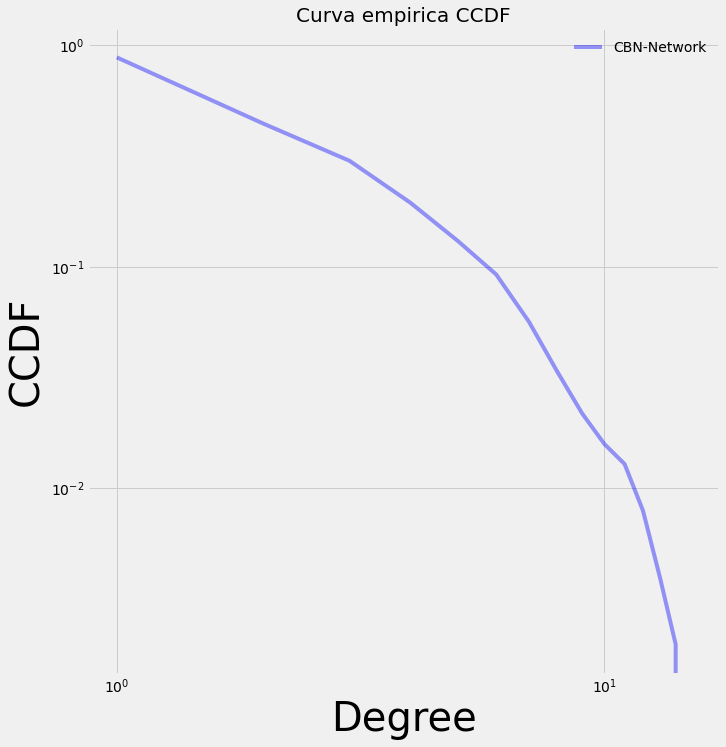

In [37]:
# grafico ccdf
degrees = [G_pesato.degree(u) for u in G_pesato]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4, label="CBN-Network")
decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.title("Curva empirica CCDF", fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()

# Random Network Erdos-Renyi

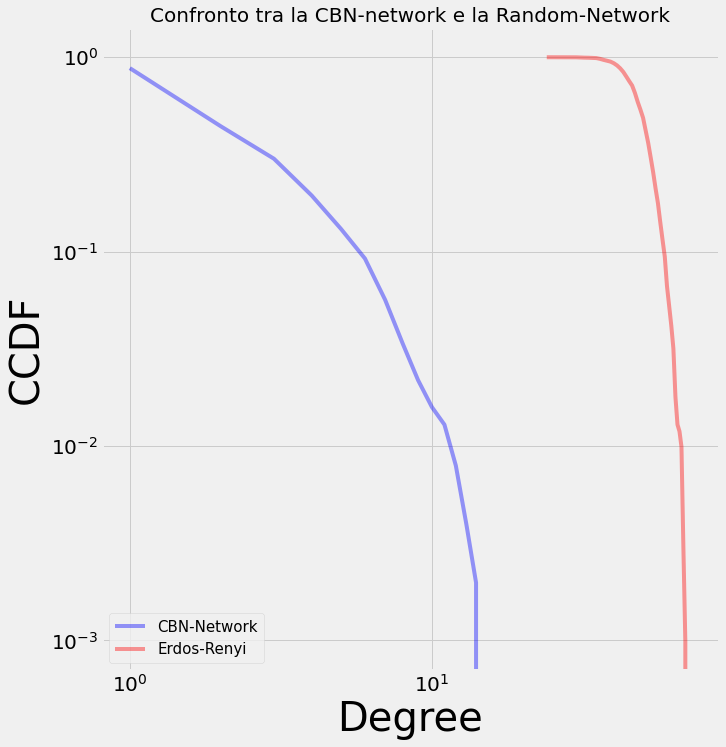

Average degree Random Network: 50.22596630327057
Average degree CBN Network: 3.191278493557978
Il global clustering della network CBN è:  0.105
Il global clustering della random network è:  0.049
L'APL della network CBN è:  23.605
L'APL della random network è:  2.028


In [38]:
erdos_renyi=nx.erdos_renyi_graph(len(G_pesato),0.05,seed=1)
degrees_er = [erdos_renyi.degree(i) for i in erdos_renyi]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4, xlabel='Degree', ylabel="CCDF", label="CBN-Network")


cdf = Cdf.from_seq(degrees_er, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Erdos-Renyi")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
                 
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la CBN-network e la Random-Network", fontsize=20)
plt.legend(fontsize=15)
plt.show()


print("Average degree Random Network:",sum(dict(erdos_renyi.degree()).values())/len(erdos_renyi))
print("Average degree CBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network CBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering della random network è: ",(round(nx.transitivity(erdos_renyi),3)))
print("L'APL della network CBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL della random network è: ",(round(nx.average_shortest_path_length(erdos_renyi),3)))


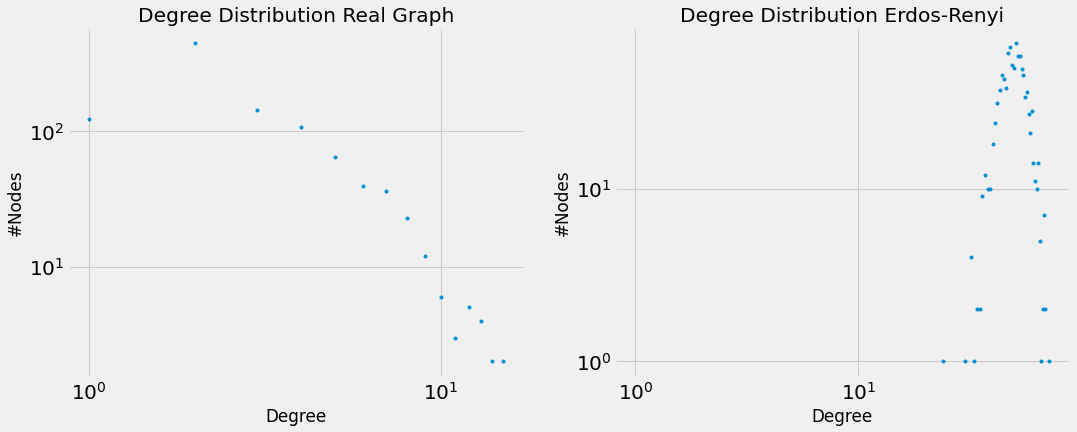

In [39]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(erdos_renyi)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Erdos-Renyi")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Small word Watts-Strogatz

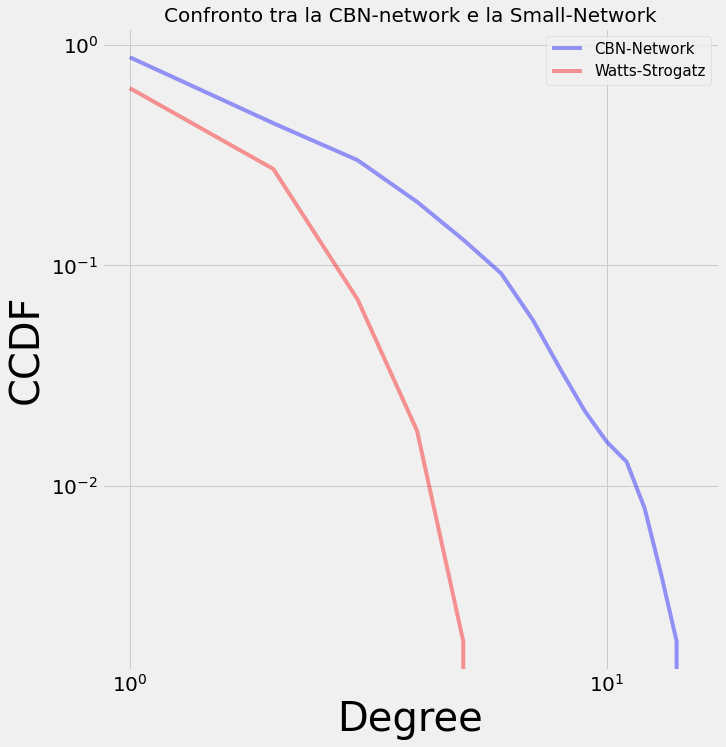

Average degree Small word: 2.0
Average degree CBN Network: 3.191278493557978
Il global clustering della network CBN è:  0.105
Il global clustering della Small word network è:  0


In [40]:
watts_strogatz = nx.watts_strogatz_graph(len(G_pesato.nodes), int(round(2*len(G_pesato.edges())/len(G_pesato))), 1, seed=1)
degrees_ws = [watts_strogatz.degree(i) for i in watts_strogatz]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="CBN-Network")


cdf = Cdf.from_seq(degrees_ws, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF",label="Watts-Strogatz")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la CBN-network e la Small-Network", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Small word:",sum(dict(watts_strogatz.degree()).values())/len(watts_strogatz))
print("Average degree CBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network CBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering della Small word network è: ",(round(nx.transitivity(watts_strogatz),3)))


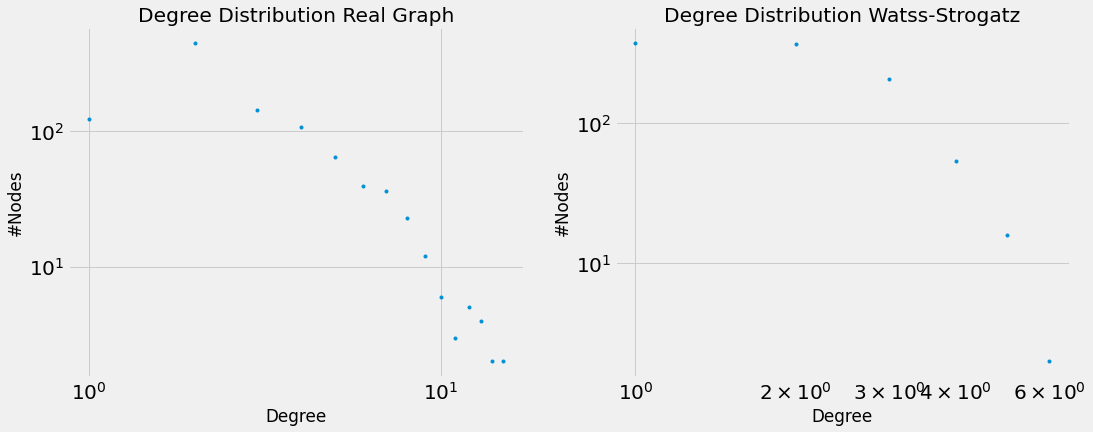

In [37]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(watts_strogatz)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Watss-Strogatz")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Barabasi Albert

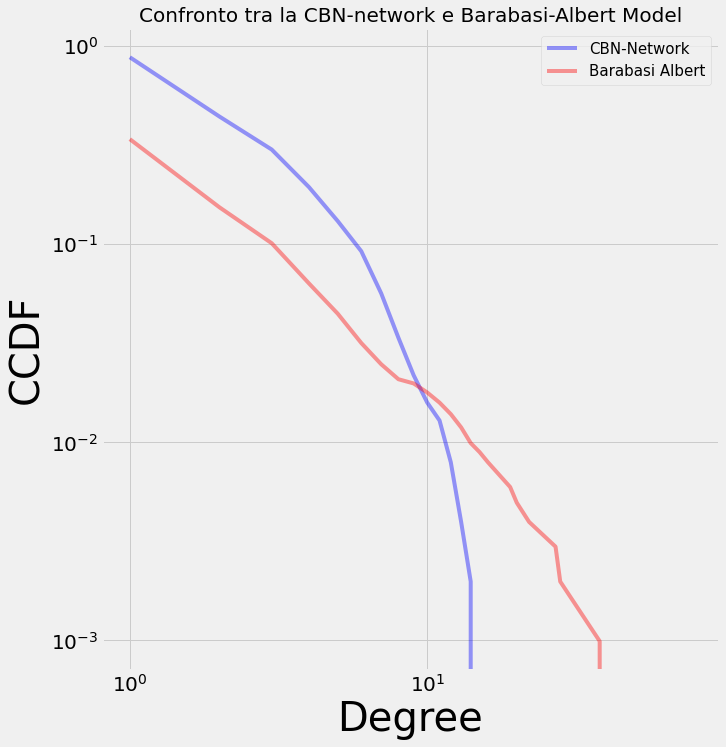

Average degree Barabasi-Albert: 1.998017839444995
Average degree CBN Network: 3.191278493557978
Il global clustering della network CBN è:  0.105
Il global clustering del modello di Barabasi-Albert è:  0
L'APL della network CBN è:  23.605
L'APL del modello di Barabasi- Albert è:  6.987


In [41]:
barabasi = nx.barabasi_albert_graph(len(G_pesato.nodes), 1,seed=1)
degrees_barabasi = [barabasi.degree(i) for i in barabasi]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="CBN-Network")


cdf = Cdf.from_seq(degrees_barabasi, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF",label="Barabasi Albert")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
                 
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la CBN-network e Barabasi-Albert Model", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Barabasi-Albert:",sum(dict(barabasi.degree()).values())/len(barabasi))
print("Average degree CBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network CBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering del modello di Barabasi-Albert è: ",(round(nx.transitivity(barabasi),3)))
print("L'APL della network CBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL del modello di Barabasi- Albert è: ",(round(nx.average_shortest_path_length(barabasi),3)))

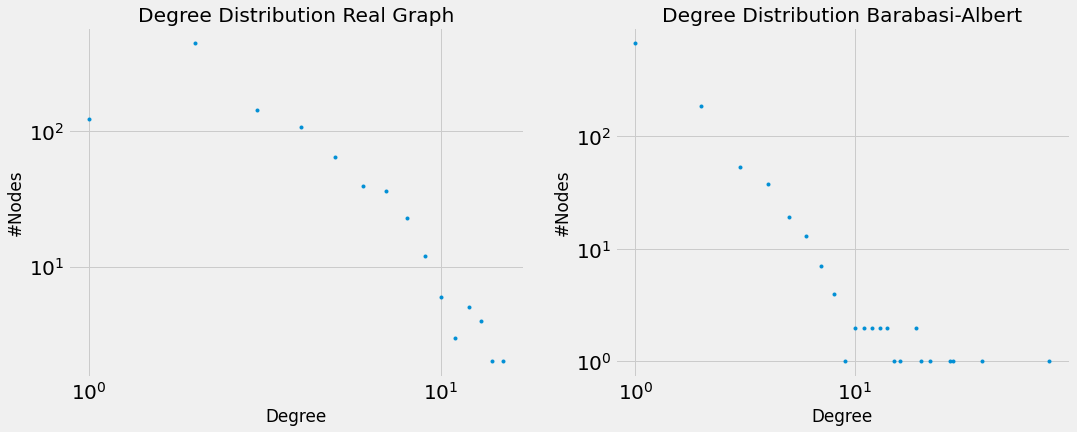

In [42]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(barabasi)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Barabasi-Albert")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Confronto tra i vari modelli della CCDF

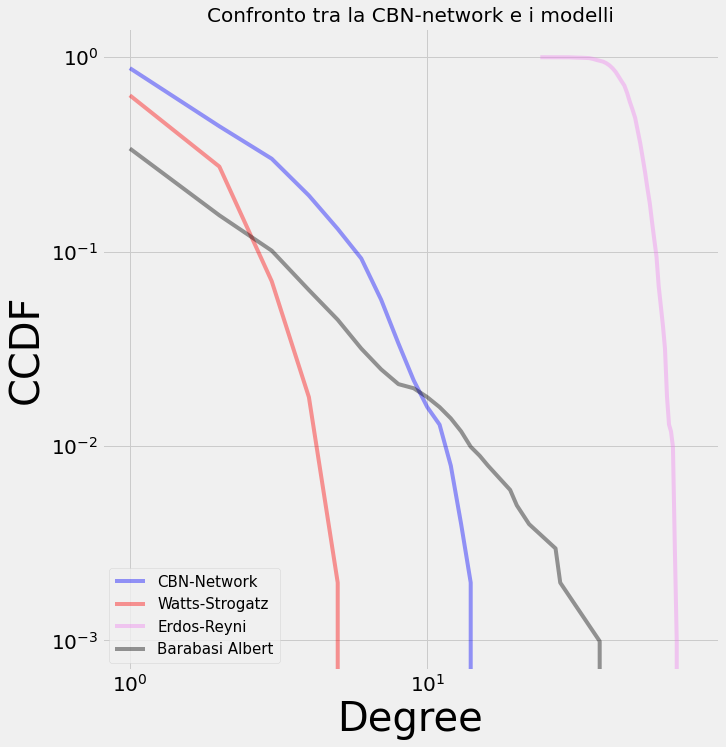

In [43]:
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="CBN-Network")

cdf = Cdf.from_seq(degrees_ws, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Watts-Strogatz")

cdf = Cdf.from_seq(degrees_er, name='distribution')
(1 - cdf).plot(color='violet', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Erdos-Reyni")

cdf = Cdf.from_seq(degrees_barabasi, name='distribution')
(1 - cdf).plot(color='black', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Barabasi Albert")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
plt.legend(["CBN-Network","Watts-Strogatz","Erdos-Renyi","Barabasi-Albert"])
plt.title("Confronto tra la CBN-network e i modelli", fontsize=20)
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.legend(fontsize=15)
plt.show()